In [1]:
import warnings 
warnings.filterwarnings('ignore')

# 데이터 로드

In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df['target'] = cancer.target
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# 데이터 분할

In [3]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(
    data_df.drop("target", axis=1),
    data_df['target'],
    random_state=42
)

# Voting Classifier 사용

In [4]:
from sklearn.ensemble import VotingClassifier

# VotingClassifier에 들어갈 모델
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [5]:
# Ensemble할 모델 객체 생성
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=3)

# predict_proba가 지원되지 않는 모델은 소프트보팅에 참여 불가능!
# svc_clf = LinearSVC()

estimators = [
    ("LR", lr_clf),
    ("KNN", knn_clf),
    #("SVC", svc_clf)
]

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현
vo_clf = VotingClassifier(
    estimators=estimators,
    voting='soft' # 확률 평균 내는 방식
)

In [6]:
vo_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('KNN', KNeighborsClassifier(n_neighbors=3))],
                 voting='soft')

# 성능평가

In [7]:
from sklearn.metrics import accuracy_score

pred = vo_clf.predict(X_test)
print("VotingClassifier 정확도 : {:.3f}".format(accuracy_score(y_test, pred)))

VotingClassifier 정확도 : 0.958


In [8]:
# 개별 모델 성능 확인
for estimator in vo_clf.estimators_:
  pred = estimator.predict(X_test)
  class_name= estimator.__class__.__name__
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test , pred)))

LogisticRegression 정확도: 0.9580
KNeighborsClassifier 정확도: 0.9301


# RandomForest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [10]:
forest_clf = RandomForestClassifier(n_estimators=5, random_state=2)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

In [11]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y, ax):
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

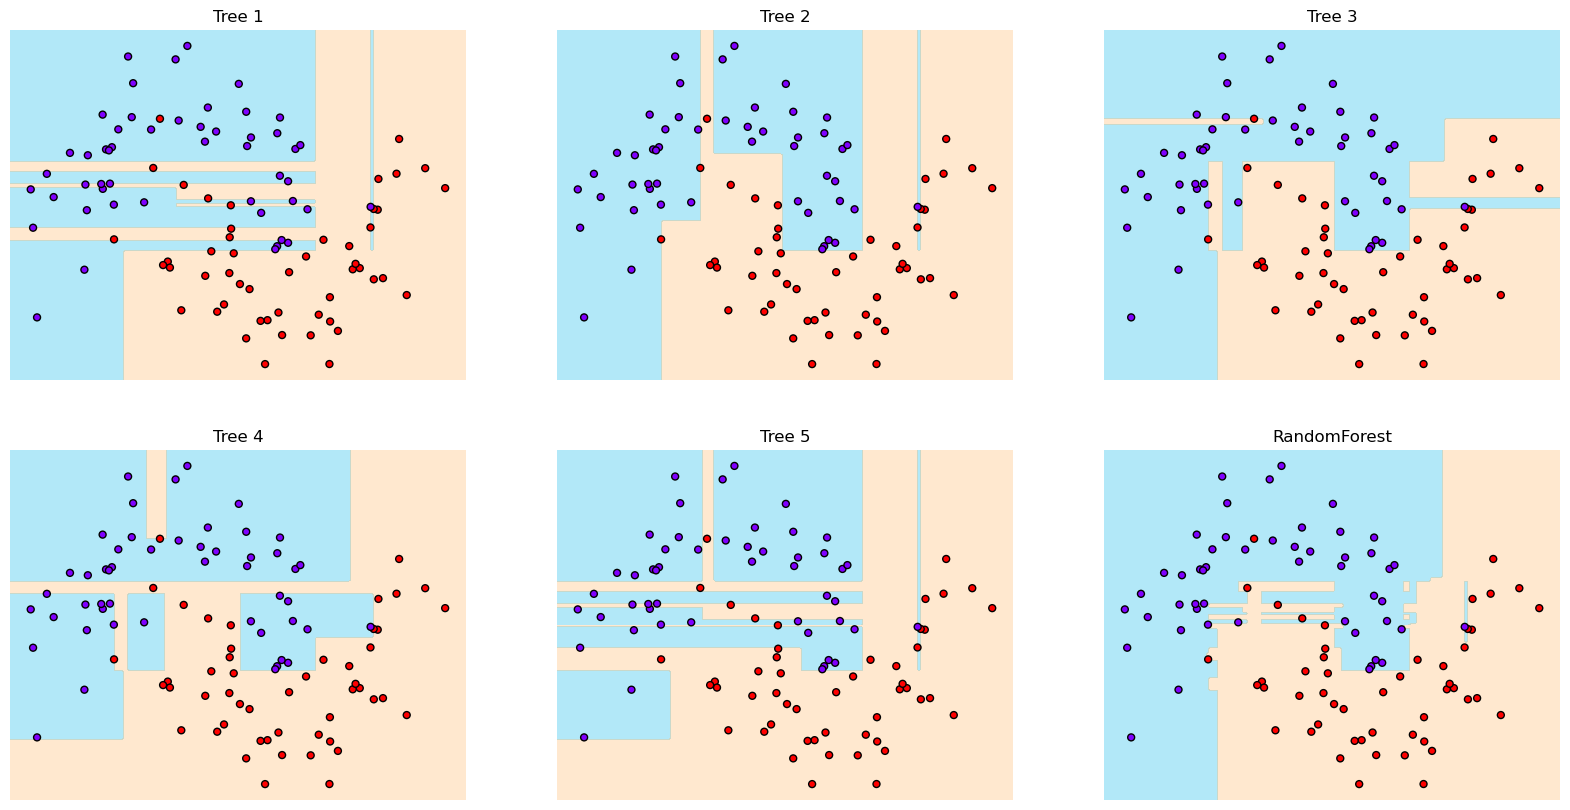

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest_clf.estimators_)): # 1차원 배열로 접근
  ax.set_title("Tree {}".format(i+1))
  visualize_boundary(tree, X, y, ax)

# 제일 마지막 ax 에는 RandomForest
axes.ravel()[-1].set_title("RandomForest")
visualize_boundary(forest_clf, X, y, axes.ravel()[-1])

plt.show()
# 서로 다른 방식으로 과대적합되게 보고 있다.

In [13]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(
    data_df.drop("target", axis=1),
    data_df['target'],
    random_state=42
)

In [14]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators" : [10, 100]
}

# grid_search 객체 생성
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid = params,
    scoring = 'accuracy',
    cv=5
)

In [15]:
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [10, 100]}, scoring='accuracy')

In [16]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성. 
cv_results_df = pd.DataFrame(rf_grid_search.cv_results_)

# max_depth,min_samples_split 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_n_estimators', 'mean_test_score']]

,param_n_estimators,mean_test_score
0,10,0.946019
1,100,0.957729


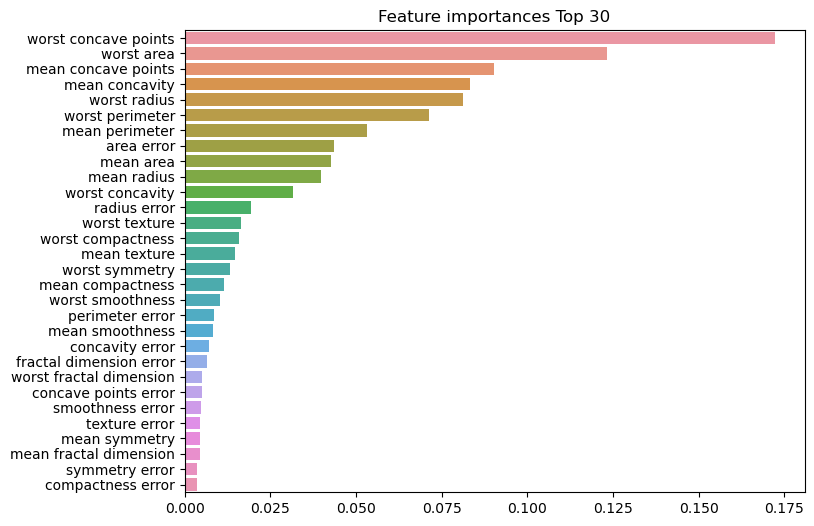

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_feature_importance(model, columns, limit=None):
 
  ftr_importances_values = model.feature_importances_
  # Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
  ftr_importances = pd.Series(ftr_importances_values, index=columns  )
  # 중요도값 순으로 Series를 정렬
  ftr_top = ftr_importances.sort_values(ascending=False)[:limit]
  plt.figure(figsize=(8,6))
  plt.title(f'Feature importances Top {len(columns) if limit == None else limit}')
  sns.barplot(x=ftr_top , y = ftr_top.index)
  plt.show()
  
plot_feature_importance(rf_grid_search.best_estimator_, X_train.columns)

In [18]:
# DecisionTree와의 비교를 위해 객체 생성
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8, 12, 16 ,20], 
    'min_samples_split' : [16, 24],
}

dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=params,
    cv=5,
    scoring='accuracy'
)

dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [8, 12, 16, 20],
                         'min_samples_split': [16, 24]},
             scoring='accuracy')

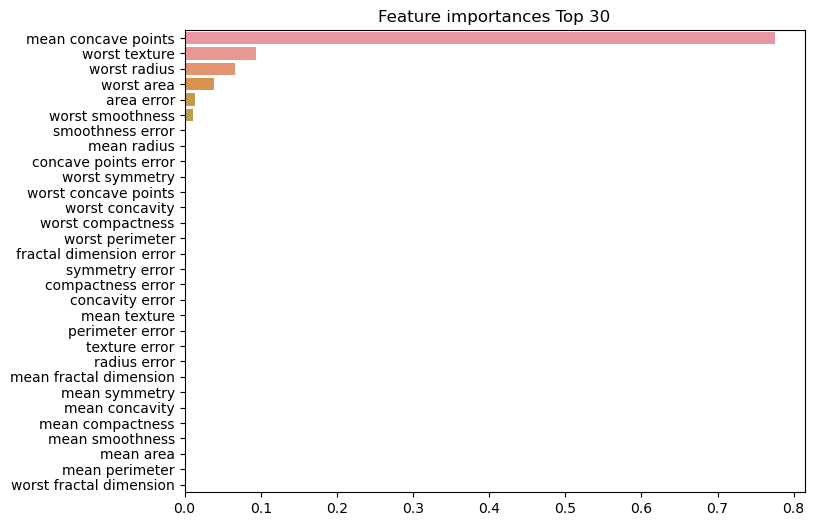

In [19]:
plot_feature_importance(dt_grid_search.best_estimator_, X_train.columns)

RandomForest는 모든 feature에 대한 특성 중요도를 파악

반면 DecisionTree는 균일도를 높일 수 있는 특성만 파악